## Downloading logs_resnet folder from google drive

my logs_resnet folder is too big. So I kept it on google drive and the link is 
https://drive.google.com/drive/u/0/folders/1jQrCOB_hanuisX8gueD_wLhd8V3dYLlF

In [ ]:
!pip install gdown

In [2]:
import gdown
url = "https://drive.google.com/drive/u/0/folders/1jQrCOB_hanuisX8gueD_wLhd8V3dYLlF"
gdown.download_folder(url, quiet=True, use_cookies=False)

['/Users/agniksaha/Downloads/pytorch_cl2/resnet_21CS60A01_agnik/resnet_best.pth',
 '/Users/agniksaha/Downloads/pytorch_cl2/resnet_21CS60A01_agnik/resnet_false.pth']

### Importing necessary modules

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import models, transforms
import numpy as np
import shutil
import matplotlib.pyplot as plt

Save the weights corresponding to the minimum validation loss in a folder
‘logs_resnet/’
I am creating two folders named checkpoints and logs_resnet.
checkpoints will contain current checkpoints and logs_resnet will contain minimum validation loss

In [2]:
%mkdir logs_resnet 

In [2]:
torch.manual_seed(1) # my roll is 21CS60A01..taking last two digits as 1

### Loading training, validation and test dataset 

In [3]:
import pickle
with open("euroSAT_train_val_test.pkl", 'rb') as f:
    train_set, val_set, test_set = pickle.load(f)
    print (len(train_set), len(val_set), len(test_set)) # 18792 2808 5400
    print (train_set[0][0].shape, train_set[0][1]) # (3, 64, 64) 7

18792 2808 5400
(3, 64, 64) 7


###  Preparing train_loader , val_loader & test_loader

In [4]:
from torch.utils.data import DataLoader

train_loader  = DataLoader(train_set, batch_size = 64, shuffle= True)


In [5]:
val_loader = torch.utils.data.DataLoader(val_set,batch_size=64, shuffle=False)

In [6]:
test_loader=DataLoader(dataset=test_set, batch_size=64, shuffle=False)

This is the device selection. If anyone has gpu, the model will be trained faster

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### train_model function trains the model and this function returns training accuracy and training loss

In [8]:
def train_model(model, loss_function, optimizer, data_loader):
    # set model to training mode
    model.train()

    current_loss = 0.0
    current_acc = 0

    # iterate over the training data
    for i, (inputs, labels) in enumerate(data_loader):
        # send the input/labels to the GPU
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        with torch.set_grad_enabled(True):
            # forward
            outputs = model(inputs)
            _, predictions = torch.max(outputs, 1)
            loss = loss_function(outputs, labels)

            # backward
            loss.backward()
            optimizer.step()

        # statistics
        current_loss += loss.item() * inputs.size(0)
        current_acc += torch.sum(predictions == labels.data)

    total_loss = current_loss / len(data_loader.dataset)
    total_acc = current_acc.double() / len(data_loader.dataset)

    print('Train Loss: {:.4f};    Train Accuracy: {:.4f}'.format(total_loss, total_acc))
    return total_acc,total_loss

### validate_model function test the model and this function returns test accuracy and test loss

In [9]:
def validate_model(model, loss_function, data_loader):
    # set model in evaluation mode
    model.eval()

    current_loss = 0.0
    current_acc = 0

    # iterate over  the validation data
    for i, (inputs, labels) in enumerate(data_loader):
        # send the input/labels to the GPU
        inputs = inputs.to(device)
        labels = labels.to(device)

        # forward
        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            _, predictions = torch.max(outputs, 1)
            loss = loss_function(outputs, labels)

        # statistics
        current_loss += loss.item() * inputs.size(0)
        current_acc += torch.sum(predictions == labels.data)

    total_loss = current_loss / len(data_loader.dataset)
    total_acc = current_acc.double() / len(data_loader.dataset)

    print('Validation Loss: {:.4f};    Validation Accuracy: {:.4f}'.format(total_loss, total_acc))
    return total_acc,total_loss

### Define our model

In [5]:
def resnet_eurosat_classifier():
    model = models.resnet18(pretrained=True)

    # replace the last layer
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, 10)

    # transfer the model to the GPU
    model = model.to(device)
    return model

### Model fitting step

In [11]:
def fit(epochs,valid_loss_min):
    # load the pre-trained model
    best_acc = 0 # variable to store best accuracy
    
    # lists to store accuracies and losses
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    
    # our model
    model = resnet_eurosat_classifier()

    # loss function
    loss_function = nn.CrossEntropyLoss()

    # We'll optimize all parameters
    optimizer = optim.Adam(model.parameters())

    # train
    for epoch in range(epochs):
        print('Epoch {}/{}'.format(epoch + 1, epochs))

        train_acc, train_loss = train_model(model, loss_function, optimizer, train_loader)
        val_acc, valid_loss = validate_model(model, loss_function, val_loader)
        
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        val_losses.append(valid_loss)
        val_accuracies.append(val_acc)       


        
        ## save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,valid_loss))
            torch.save(model.state_dict(), './logs_resnet/resnet_best.pth')
            valid_loss_min = valid_loss
            
        # implementing early stopping code
        if val_acc > best_acc:
            best_acc = val_acc
            es = 0
        else:
            es += 1
            print("Counter {} of 5 (early stopping)".format(es))

            if es > 4:
                print("Early stopping with best_acc: ", best_acc, "and val_acc for this epoch: ", val_acc, "...")
                break
                
    return train_losses,train_accuracies,val_losses,val_accuracies


In [15]:
valid_loss_min = np.Inf
epochs=15
train_losses,train_accuracies,val_losses,val_accuracies = fit(epochs,valid_loss_min)

Epoch 1/15
Train Loss: 0.3978;    Train Accuracy: 0.8748
Validation Loss: 0.2755;    Validation Accuracy: 0.9117
Validation loss decreased (inf --> 0.275550).  Saving model ...
Epoch 2/15
Train Loss: 0.2218;    Train Accuracy: 0.9308
Validation Loss: 0.3236;    Validation Accuracy: 0.8978
Counter 1 of 5 (early stopping)
Epoch 3/15
Train Loss: 0.1783;    Train Accuracy: 0.9432
Validation Loss: 0.1983;    Validation Accuracy: 0.9402
Validation loss decreased (0.275550 --> 0.198340).  Saving model ...
Epoch 4/15
Train Loss: 0.1328;    Train Accuracy: 0.9576
Validation Loss: 0.1557;    Validation Accuracy: 0.9459
Validation loss decreased (0.198340 --> 0.155703).  Saving model ...
Epoch 5/15
Train Loss: 0.1230;    Train Accuracy: 0.9626
Validation Loss: 0.4340;    Validation Accuracy: 0.8729
Counter 1 of 5 (early stopping)
Epoch 6/15
Train Loss: 0.0960;    Train Accuracy: 0.9685
Validation Loss: 0.1901;    Validation Accuracy: 0.9423
Counter 2 of 5 (early stopping)
Epoch 7/15
Train Loss: 0

In [16]:
train_losses

[0.39784407510991904,
 0.22179807837388016,
 0.17827820412500608,
 0.1327907278746836,
 0.12300089768599125,
 0.0959861059124011,
 0.0800286940865539,
 0.07301372567587404,
 0.08173983323115422]

In [17]:
train_accuracies 

[tensor(0.8748, dtype=torch.float64),
 tensor(0.9308, dtype=torch.float64),
 tensor(0.9432, dtype=torch.float64),
 tensor(0.9576, dtype=torch.float64),
 tensor(0.9626, dtype=torch.float64),
 tensor(0.9685, dtype=torch.float64),
 tensor(0.9742, dtype=torch.float64),
 tensor(0.9761, dtype=torch.float64),
 tensor(0.9740, dtype=torch.float64)]

In [18]:
val_losses

[0.2755497490663474,
 0.32359387723468985,
 0.19833961014564222,
 0.1557029178764066,
 0.4340145871510193,
 0.1901016018838964,
 0.39300194722295145,
 0.317643141389912,
 0.3596151396419927]

In [19]:
val_accuracies

[tensor(0.9117, dtype=torch.float64),
 tensor(0.8978, dtype=torch.float64),
 tensor(0.9402, dtype=torch.float64),
 tensor(0.9459, dtype=torch.float64),
 tensor(0.8729, dtype=torch.float64),
 tensor(0.9423, dtype=torch.float64),
 tensor(0.8871, dtype=torch.float64),
 tensor(0.9135, dtype=torch.float64),
 tensor(0.9110, dtype=torch.float64)]

## Plots of loss and accuracy on the training and validation sets

In [27]:
# importing the required module
def plot_accuracies(train_accuracies,val_accuracies):
    plt.plot(train_accuracies, '-rx')
    plt.plot(val_accuracies, '-bx')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(['Training', 'Validation'])
    plt.title('Accuracy vs. No. of epochs')

    

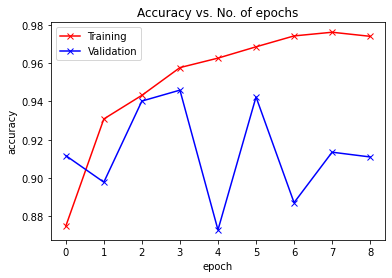

In [20]:
plot_accuracies(train_accuracies,val_accuracies)

In [29]:
def plot_losses(train_losses,val_losses):
    plt.plot(train_losses, '-rx')
    plt.plot(val_losses, '-bx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('loss vs. No. of epochs')

    

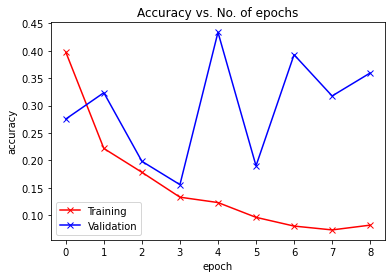

In [21]:
plot_losses(train_losses,val_losses)

## Loading the model
- Load the state dict to the model


In [7]:
model = resnet_eurosat_classifier()
#model.load_state_dict(torch.load('./logs_resnet/resnet_best.pth'))
model.load_state_dict(torch.load('./resnet_best.pth'))
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Output the predicted value from a test dataset

In [31]:
def get_all_preds(model, loader):
    preds = torch.tensor([])
    true_labels = torch.tensor([])
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            true_labels = torch.cat((true_labels,labels),dim = 0)
            preds = torch.cat((preds,predicted),dim = 0)
    return true_labels,preds

### REPORT THE ACCURACY ON TEST DATA

In [14]:
labels,preds = get_all_preds(model, test_loader)

In [15]:
count = 0
for i in range(len(labels)):
    if preds[i] == labels[i]:
        count = count+1
acc_test = count/ len(labels)
print(f'Accuracy of test data is {acc_test}\n')

Accuracy of test data is 0.9448148148148148



### REPORT THE VALIDATION ACCURACY ON TEST DATA

In [16]:
labels_val,preds_val = get_all_preds(model, val_loader)
count1 = 0
for i in range(len(labels_val)):
    if preds_val[i] == labels_val[i]:
        count1 = count1+1
acc_val = count1/ len(labels_val)
print(f'Accuracy of validation data is {acc_val}\n')

Accuracy of validation data is 0.9415954415954416



## Show the recall for each class

In [29]:
from sklearn.metrics import recall_score

In [30]:
y_true, y_pred = get_all_preds(model, test_loader)
y_true = y_true.tolist()
y_pred = y_pred.tolist()
recall = recall_score(y_true, y_pred, average=None)
print(recall)

[0.96       0.98       0.89333333 0.942      0.966      0.9075
 0.884      0.98333333 0.922      0.98666667]


### Write the results for test data for submission on kaggle

In [31]:
labels,preds = get_all_preds(model, test_loader)

In [32]:
preds = [int(x) for x in preds]

In [33]:
f = open("agnik_result_task_2.csv", "w+")
f.write(f'id,label\n')
count = 0
for pred in preds:
    f.write(f'{count},{pred}\n')
    count = count+1
f.close()

In [34]:
classes = ['AnnualCrop','Forest','HerbaceousVegetation','Highway','Industrial','Pasture','PermanentCrop','Residential','River','SeaLake']

In [35]:
batch_size = 4
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
        
        for i in range(batch_size):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc} %')

    for i in range(10):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {classes[i]}: {acc} %')


Accuracy of the network: 94.48148148148148 %
Accuracy of AnnualCrop: 100.0 %
Accuracy of Forest: 97.43589743589743 %
Accuracy of HerbaceousVegetation: 93.93939393939394 %
Accuracy of Highway: 96.96969696969697 %
Accuracy of Industrial: 97.14285714285714 %
Accuracy of Pasture: 100.0 %
Accuracy of PermanentCrop: 84.0 %
Accuracy of Residential: 97.5 %
Accuracy of River: 90.3225806451613 %
Accuracy of SeaLake: 97.72727272727273 %


### Plot four examples the model got wrong and was most confident about. Also add the true class and the predicted class along with the image. One such example is shown below

In [36]:
classes = ['AnnualCrop','Forest','HerbaceousVegetation','Highway','Industrial','Pasture','PermanentCrop','Residential','River','SeaLake']


In [37]:
type(recall)

numpy.ndarray

In [38]:
# recall means the percentage of a certain class correctly identified
# model was confident about the class whose recall value is maximum
recall_list = list(recall)

In [39]:
recall_list

[0.96,
 0.98,
 0.8933333333333333,
 0.942,
 0.966,
 0.9075,
 0.884,
 0.9833333333333333,
 0.922,
 0.9866666666666667]

In [40]:
max_recall_val = recall_list.index(max(recall_list))
max_recall_val

9

### Seperating Test_images, their true labels and their predicted labels for my convinience

In [41]:
preds = torch.tensor([])
img_test = torch.tensor([])
label_test = torch.tensor([])
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        label_test = torch.cat((label_test,labels),dim = 0)
        img_test = torch.cat((images,img_test),dim = 0)
        preds = torch.cat((preds,predicted),dim = 0)

In [42]:
preds = [int(x) for x in preds]


In [43]:
import matplotlib.pyplot as plt
def show_img(img):
    plt.imshow(img.permute(1,2,0))

In [44]:
label_test = [int(x) for x in label_test]

In [45]:
confident_img = []
confident_pred =[]
confident_label = []
for i in range(5400):
    label, img, prediction = label_test[i],img_test[i], preds[i]
    if label == max_recall_val and prediction != label :
        confident_img.append(img)
        confident_pred.append(prediction)
        confident_label.append(label)
        
        

In [46]:
len(confident_label)

8

True: SeaLake 	 Predicted: AnnualCrop


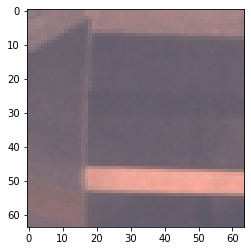

In [47]:
show_img(confident_img[0])
print(f'True: {classes[confident_label[0]]} \t Predicted: {classes[confident_pred[0]]}')

True: SeaLake 	 Predicted: Forest


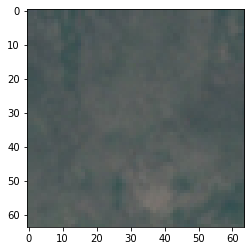

In [48]:
show_img(confident_img[1])
print(f'True: {classes[confident_label[1]]} \t Predicted: {classes[confident_pred[1]]}')

True: SeaLake 	 Predicted: Forest


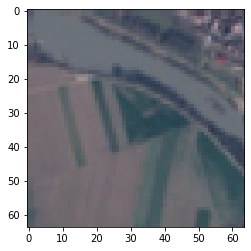

In [49]:
show_img(confident_img[2])
print(f'True: {classes[confident_label[2]]} \t Predicted: {classes[confident_pred[2]]}')

True: SeaLake 	 Predicted: AnnualCrop


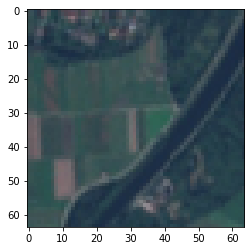

In [51]:
show_img(confident_img[3])
print(f'True: {classes[confident_label[3]]} \t Predicted: {classes[confident_pred[3]]}')

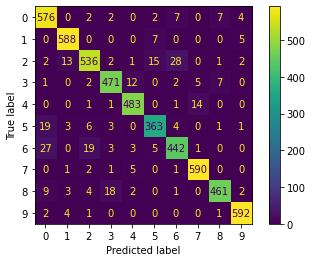

In [50]:
y_true, y_pred = get_all_preds(model, test_loader)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

### Retrain the model with the same hyper parameters, but keep pretrained=False

In [8]:
def resnet_eurosat_classifier_2():
    model = models.resnet18(pretrained=False)

    # replace the last layer
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, 10)

    # transfer the model to the GPU
    model = model.to(device)
    return model

In [20]:
def fit(epochs,valid_loss_min, model, path):
    # load the pre-trained model
    best_acc = 0 # variable to store best accuracy
    
    # lists to store accuracies and losses
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    # loss function
    loss_function = nn.CrossEntropyLoss()

    # We'll optimize all parameters
    optimizer = optim.Adam(model.parameters())

    # train
    for epoch in range(epochs):
        print('Epoch {}/{}'.format(epoch + 1, epochs))

        train_acc, train_loss = train_model(model, loss_function, optimizer, train_loader)
        val_acc, valid_loss = validate_model(model, loss_function, val_loader)
        
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        val_losses.append(valid_loss)
        val_accuracies.append(val_acc)       


        
        ## save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,valid_loss))
            torch.save(model.state_dict(), path)
            valid_loss_min = valid_loss
            
        # implementing early stopping code
        if val_acc > best_acc:
            best_acc = val_acc
            es = 0
        else:
            es += 1
            print("Counter {} of 5 (early stopping)".format(es))

            if es > 4:
                print("Early stopping with best_acc: ", best_acc, "and val_acc for this epoch: ", val_acc, "...")
                break
                
    return train_losses,train_accuracies,val_losses,val_accuracies


In [21]:
model2 = resnet_eurosat_classifier_2()
train_loss_false,train_accuracy_false,val_loss_false,val_accuracy_false = fit(15,np.Inf,model2,'./logs_resnet/resnet_false.pth')

Epoch 1/15
Train Loss: 0.9711;    Train Accuracy: 0.6549
Validation Loss: 1.0762;    Validation Accuracy: 0.6335
Validation loss decreased (inf --> 1.076225).  Saving model ...
Epoch 2/15
Train Loss: 0.6954;    Train Accuracy: 0.7579
Validation Loss: 0.8623;    Validation Accuracy: 0.6905
Validation loss decreased (1.076225 --> 0.862303).  Saving model ...
Epoch 3/15
Train Loss: 0.5620;    Train Accuracy: 0.8034
Validation Loss: 0.7931;    Validation Accuracy: 0.7333
Validation loss decreased (0.862303 --> 0.793130).  Saving model ...
Epoch 4/15
Train Loss: 0.4745;    Train Accuracy: 0.8325
Validation Loss: 0.9402;    Validation Accuracy: 0.6838
Counter 1 of 5 (early stopping)
Epoch 5/15
Train Loss: 0.3932;    Train Accuracy: 0.8614
Validation Loss: 1.3501;    Validation Accuracy: 0.6321
Counter 2 of 5 (early stopping)
Epoch 6/15
Train Loss: 0.3434;    Train Accuracy: 0.8788
Validation Loss: 2.3567;    Validation Accuracy: 0.5360
Counter 3 of 5 (early stopping)
Epoch 7/15
Train Loss: 0

In [22]:
val_accuracy_false

[tensor(0.6335, dtype=torch.float64),
 tensor(0.6905, dtype=torch.float64),
 tensor(0.7333, dtype=torch.float64),
 tensor(0.6838, dtype=torch.float64),
 tensor(0.6321, dtype=torch.float64),
 tensor(0.5360, dtype=torch.float64),
 tensor(0.6307, dtype=torch.float64),
 tensor(0.8016, dtype=torch.float64),
 tensor(0.8251, dtype=torch.float64),
 tensor(0.7415, dtype=torch.float64),
 tensor(0.6378, dtype=torch.float64),
 tensor(0.7368, dtype=torch.float64),
 tensor(0.7208, dtype=torch.float64),
 tensor(0.6403, dtype=torch.float64)]

In [23]:
val_loss_false

[1.0762248514724253,
 0.8623034517649572,
 0.7931302799458517,
 0.9402039069735426,
 1.3501243703385704,
 2.3567124567819797,
 1.480434654784678,
 0.5580503838693994,
 0.5552488629125122,
 0.9947229448886339,
 1.5697989633619955,
 1.0766967900118596,
 1.2218407202310373,
 1.70704729774399]

In [24]:
train_accuracy_false

[tensor(0.6549, dtype=torch.float64),
 tensor(0.7579, dtype=torch.float64),
 tensor(0.8034, dtype=torch.float64),
 tensor(0.8325, dtype=torch.float64),
 tensor(0.8614, dtype=torch.float64),
 tensor(0.8788, dtype=torch.float64),
 tensor(0.8966, dtype=torch.float64),
 tensor(0.9105, dtype=torch.float64),
 tensor(0.9282, dtype=torch.float64),
 tensor(0.9380, dtype=torch.float64),
 tensor(0.9485, dtype=torch.float64),
 tensor(0.9508, dtype=torch.float64),
 tensor(0.9576, dtype=torch.float64),
 tensor(0.9639, dtype=torch.float64)]

In [25]:
train_loss_false

[0.9711133972057742,
 0.695421050499733,
 0.5619847210684752,
 0.4744982841980107,
 0.39319522680755165,
 0.3434161970644821,
 0.29376357521032365,
 0.2539638149428743,
 0.20684670956021117,
 0.17790499022535794,
 0.1482802704008349,
 0.13502620055909967,
 0.12255484058583935,
 0.10611714175936007]

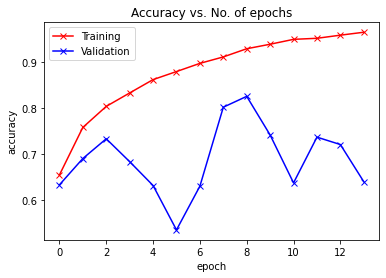

In [28]:
# importing the required module
plot_accuracies(train_accuracy_false,val_accuracy_false)

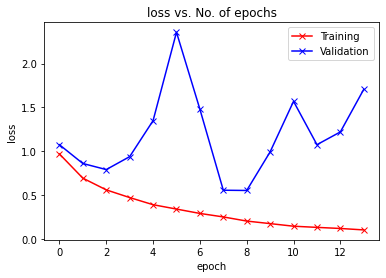

In [30]:
plot_losses(train_loss_false,val_loss_false)

## Loading the model

In [9]:
model2 = resnet_eurosat_classifier_2()
# model2.load_state_dict(torch.load('./logs_resnet/resnet_false.pth'))
model2.load_state_dict(torch.load('./resnet_false.pth'))
model2.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [37]:
labels_false,preds_false = get_all_preds(model2, test_loader)

In [38]:
def accuracy(labels,preds):
    count = 0
    for i in range(len(labels)):
        if preds[i] == labels[i]:
            count = count+1
    acc_test = count/ len(labels)
    return acc_test

In [39]:
res = accuracy(labels_false,preds_false)
print(f'Accuracy of test data when pretrained = false is {res}\n')

Accuracy of test data when pretrained = false is 0.875



In [40]:
labels_val_false,preds_val_false = get_all_preds(model2, val_loader)
res2 = accuracy(labels_val_false,preds_val_false)
print(f'Accuracy of validation data when pretrained = false is {res2}\n')

Accuracy of validation data when pretrained = false is 0.8796296296296297

